##VAE encoder network

In [ ]:
"""
Convnet that maps the input image x to two vectors, z_mean and z_log_var. Use strides for 
downsampling feature maps, instead of max pooling. Strides are preferable to max pooling
for any model that cares about information location to reconstruct a valid image.
"""
from tensorflow import keras
from tensorflow.keras import layers

latent_dim = 2 # 2D latent space

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)

# input image are encoded into these parameters
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

In [ ]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3136)         0           conv2d_1[0][0]                   
____________________________________________________________________________________________

## Latent-space-sampling layer

In [ ]:
"""
The code for using z_mean and z_log_var. Use the parameters of the statistical distribution 
assumed to have produced input_img, to generate a latent space point z
""" 
import tensorflow as tf

class Sampler(layers.Layer):
    def call(self, z_mean, z_log_var):
        batch_size = tf.shape(z_mean)[0]
        z_size = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch_size, z_size)) # batch of random normal vectors
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon # Apply VAE sampling formula

## VAE decoder network, mapping latent space points to images

In [ ]:
"""
The decoder implementation. Reshape the vector z to the dimensions of an image and 
use a few convolution layers to obtain a final image output that has the same dimensions 
as the original input_img.
"""
latent_inputs = keras.Input(shape=(latent_dim,)) # Feed latent space point z vector into input
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs) # same number of coefficients as the Flatten layer in the encoder
x = layers.Reshape((7, 7, 64))(x) # Revert the layer of the encoder
# Revert the layers of the encoder
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x) # output shape of (28, 28, 1)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [ ]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

## VAE model with custom train_step()

In [ ]:
"""
the VAE model itself isn’t doing supervised learning (autencoders VAE/GAN are 
examples of self-supervised learning, because they use inputs as targets). 
When departing from classic supervised learning, it’s common to subclass the 
Model class and implement a custom train_step() to specify the new training logic.
"""
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        # metrics to keep track of loss averages over each epoch
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    # metrics property to reset them after each epoch (or between multiple calls to fit/evaluate)
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker]
    # Overridding the train_step() method of the Model class
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampler(z_mean, z_log_var)
            reconstruction = decoder(z)
            # Sum reconstruction loss over spatial dimensions (axes 1 and 2) and take mean over the batch dimension
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.binary_crossentropy(data, reconstruction),axis=(1, 2)))
            # Add regularization term (Kullback–Leibler divergence)
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            total_loss = reconstruction_loss + tf.reduce_mean(kl_loss)
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "total_loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

##Train the VAE

In [ ]:
import numpy as np

(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0) # train on all MNIST digits, to concatenate the training and test samples
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True) # the loss is already part of the train_step()
vae.fit(mnist_digits, epochs=30, batch_size=128) # train_step() doesn’t expect targets/labels

11501568/11490434 [==============================] - 0s 0us/step
Epoch 1/30
547/547 [==============================] - 51s 41ms/step - total_loss: 208.7775 - reconstruction_loss: 206.8724 - kl_loss: 1.9050
Epoch 2/30
547/547 [==============================] - 22s 40ms/step - total_loss: 185.2589 - reconstruction_loss: 183.3753 - kl_loss: 1.8837
Epoch 3/30
547/547 [==============================] - 22s 40ms/step - total_loss: 168.9192 - reconstruction_loss: 165.6331 - kl_loss: 3.2861
Epoch 4/30
547/547 [==============================] - 22s 40ms/step - total_loss: 161.1842 - reconstruction_loss: 157.8784 - kl_loss: 3.3058
Epoch 5/30
547/547 [==============================] - 22s 40ms/step - total_loss: 157.7337 - reconstruction_loss: 154.3946 - kl_loss: 3.3392
Epoch 6/30
547/547 [==============================] - 22s 40ms/step - total_loss: 155.6964 - reconstruction_loss: 152.3241 - kl_loss: 3.3721
Epoch 7/30
547/547 [==============================] - 21s 39ms/step - total_loss: 154.288

## Sample a grid of points from the 2D latent space and decodem to images

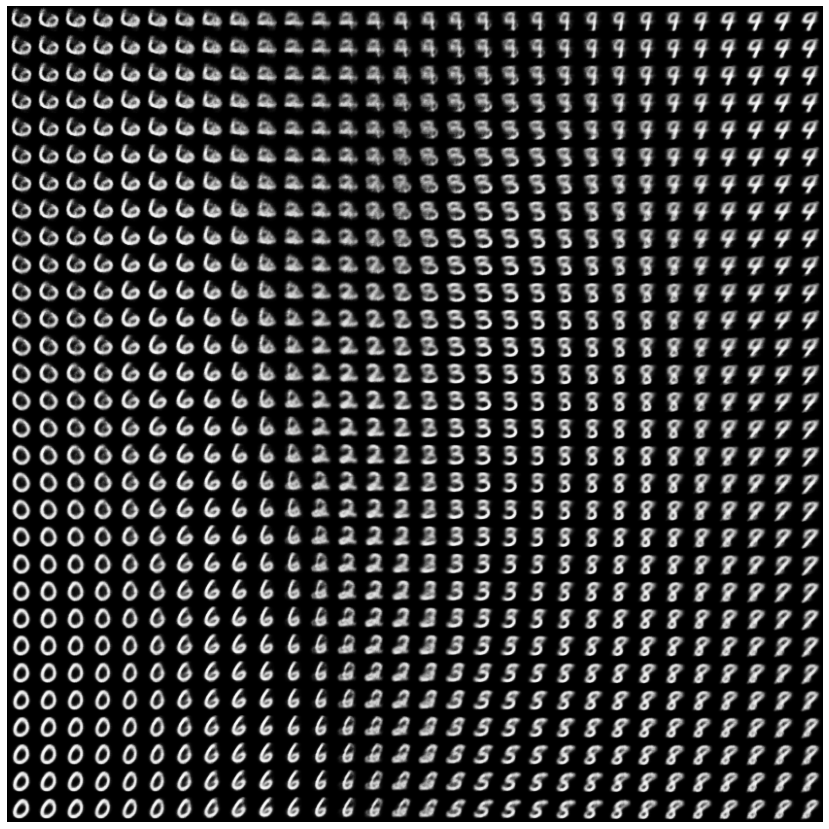

In [ ]:
# Use decoder network to turn arbitrary latent space vectors into images
import matplotlib.pyplot as plt

n = 30 # display a grid of 30 × 30 digits (900 digits total)
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Sample points linearly on a 2D grid
grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)[::-1]

# Iterate over grid locations
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        # For each location, sample a digit and add it to the figure      
        z_sample = np.array([[xi, yi]])
        x_decoded = vae.decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[
            i * digit_size : (i + 1) * digit_size,
            j * digit_size : (j + 1) * digit_size,
        ] = digit

plt.figure(figsize=(15, 15))
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.axis("off")
plt.imshow(figure, cmap="Greys_r")

# References

From the book "Deep Learning with Python" by FRANÇOIS CHOLLET.